# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression




In [2]:
future = pd.read_excel("data/futures.xlsx", header=0)

In [3]:
future["date"]= pd.to_datetime(future["date"])
future.ffill(inplace=True)
future = future[future['date'] <= "2023-01-01"]
future.head()

,date,TRFRBYc1,TRFRBMc1,TRFRBFVMG6,TRFRBFVMH6,TRFRBFVMJ6,TRFRBFVMK6,TRFRBFVMM6,TRFRBFVMN6,TRFRBFVMQ6,...,TRFRBFVMH7,TRFRBFVMJ7,TRFRBFVMK7,TRFRBFVMM7,TRFRBFVMN7,TRFRBFVMQ7,TRFRBFVMU7,TRFRBFVMV7,TRFRBFVMX7,TRFRBFVMZ7
789,2022-12-30,245.00,202.0,162.85,147.12,115.84,103.95,101.40,102.91,110.96,...,135.40,105.99,92.64,92.72,94.45,100.84,117.78,152.02,163.86,162.26
790,2022-12-29,269.75,230.0,161.31,145.57,114.32,102.43,99.88,101.27,109.32,...,134.56,104.78,91.57,91.86,93.21,99.71,116.73,151.04,162.93,161.33
791,2022-12-28,274.00,240.0,166.20,151.23,109.20,99.74,97.55,98.32,106.83,...,141.58,99.22,88.97,90.63,91.19,97.40,112.55,159.32,168.87,166.42
792,2022-12-27,276.00,266.0,168.71,153.69,108.19,98.71,96.48,97.22,105.71,...,143.68,98.29,88.26,89.80,90.48,96.64,111.50,158.52,168.02,165.58
793,2022-12-26,276.00,266.0,166.46,156.30,95.84,93.83,91.22,90.94,101.84,...,139.45,78.74,78.48,80.38,79.59,86.55,93.88,158.16,158.22,156.62


In [4]:
# Lecture et traitement des fichiers Spot22, Spot23, Spot24, Spot25
spot_files = ["data/spot_price_16.xlsx","data/spot_price_17.xlsx","data/spot_price_18.xlsx","data/spot_price_19.xlsx","data/spot_price_20.xlsx","data/spot_price_21.xlsx","data/spot_price_22.xlsx", "data/spot_price_23.xlsx", "data/spot_price_24.xlsx", "data/spot_price_25.xlsx"]
spot_data = []

for file in spot_files:
    spot = pd.read_excel(file)
    spot['Date'] = spot['Date'].str.split(' - ').str[0]  # Prendre uniquement le début de la plage
    spot['Date'] = pd.to_datetime(spot['Date'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    spot = spot.dropna(subset=['Date'])  # Suppression des lignes avec des dates invalides
    daily = spot.groupby(spot['Date'].dt.date)['Day-ahead'].mean().reset_index()
    daily.rename(columns={'Date': 'date', 'Day-ahead': 'price'}, inplace=True)
    spot_data.append(daily)

# Fusion des bases de données
spot_merged = pd.concat(spot_data).groupby('date', as_index=False)['price'].mean()

# Affichage des premières lignes du résultat
spot_merged.head()


,date,price
0,2016-01-01,23.888750
1,2016-01-02,23.198750
2,2016-01-03,18.003750
3,2016-01-04,28.229583
4,2016-01-05,33.877083


In [5]:
spot_merged.loc[spot_merged['price'] <= 0, 'price'] = np.nan
spot_merged['price'] = spot_merged['price'].ffill()

# I. Modélisation du spot

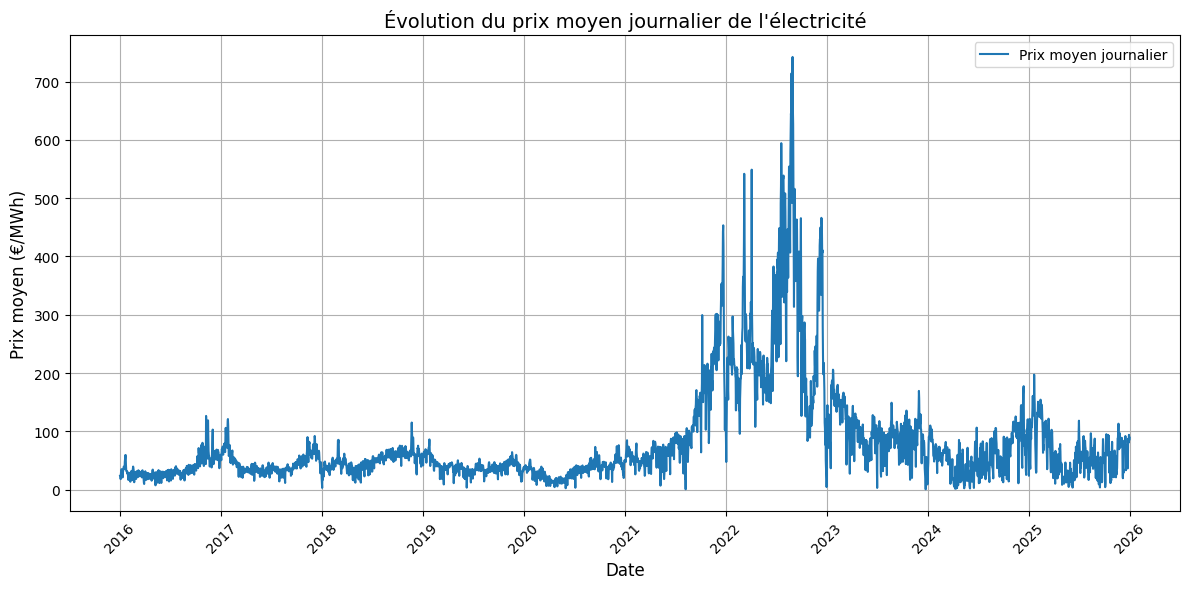

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Convertir la colonne 'date' en type datetime64 pour éviter les incompatibilités de types
spot_merged['date'] = pd.to_datetime(spot_merged['date'])

# Filtrer les données pour conserver uniquement les dates à partir du 1er janvier 2023
spot_merged = spot_merged[spot_merged['date'] >= pd.Timestamp('2023-01-01')]


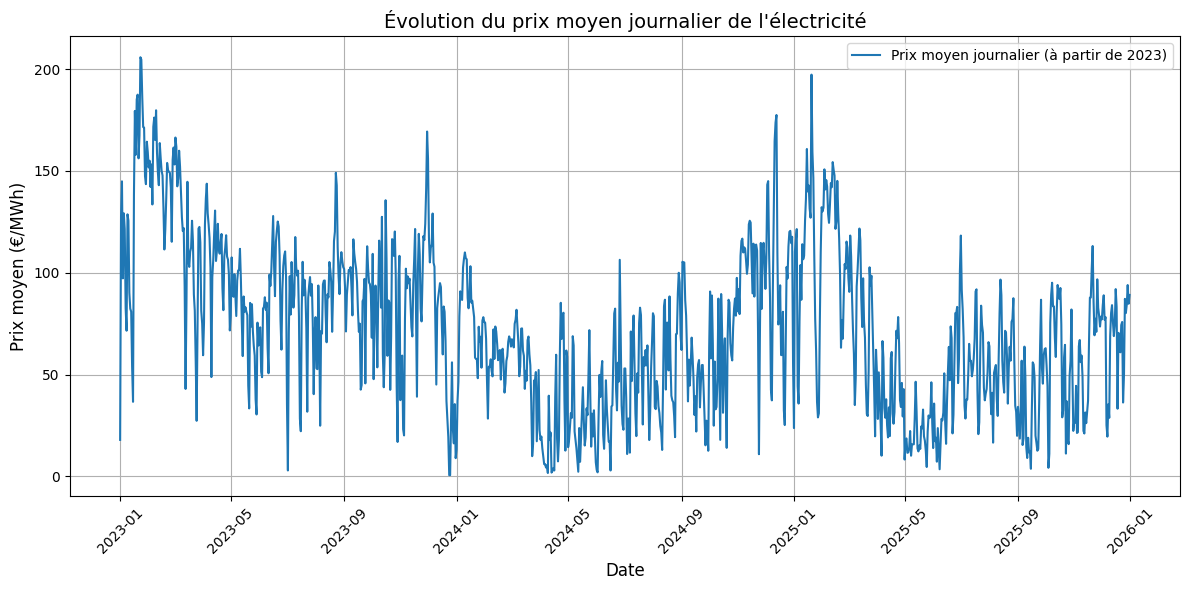

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(spot_merged['date'], spot_merged['price'], linestyle='-', label='Prix moyen journalier (à partir de 2023)')
plt.title("Évolution du prix moyen journalier de l'électricité", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Ajouter des colonnes "jour", "mois", "semaine" et "saison"
spot_merged['jour'] = spot_merged['date'].dt.day_name()
spot_merged['mois'] = spot_merged['date'].dt.month_name()
spot_merged['semaine'] = spot_merged['date'].dt.isocalendar().week
spot_merged['saison'] = spot_merged['date'].dt.month % 12 // 3 + 1
spot_merged['saison'] = spot_merged['saison'].map({1: 'Hiver', 2: 'Printemps', 3: 'Été', 4: 'Automne'})


Statistiques descriptives par jour de la semaine:
           count       mean        std        min        25%        50%  \
jour                                                                      
Friday     156.0  77.547948  37.992099   6.008333  54.388229  78.793073   
Monday     157.0  76.072197  40.311244   0.600000  46.892917  73.590417   
Saturday   156.0  61.733245  36.331542   1.858750  31.779896  56.751875   
Sunday     157.0  51.744751  37.181654   0.597500  19.778750  45.536667   
Thursday   156.0  79.254841  39.663877   7.231667  52.840833  80.168281   
Tuesday    157.0  79.423432  40.004813   1.659167  49.847917  77.178333   
Wednesday  157.0  80.163034  38.417830  13.785417  51.245417  82.275833   

                  75%         max  
jour                               
Friday      99.009062  187.445833  
Monday     101.276667  205.830000  
Saturday    86.250208  156.182500  
Sunday      74.291250  167.334167  
Thursday   105.515104  185.080833  
Tuesday    105.366250 

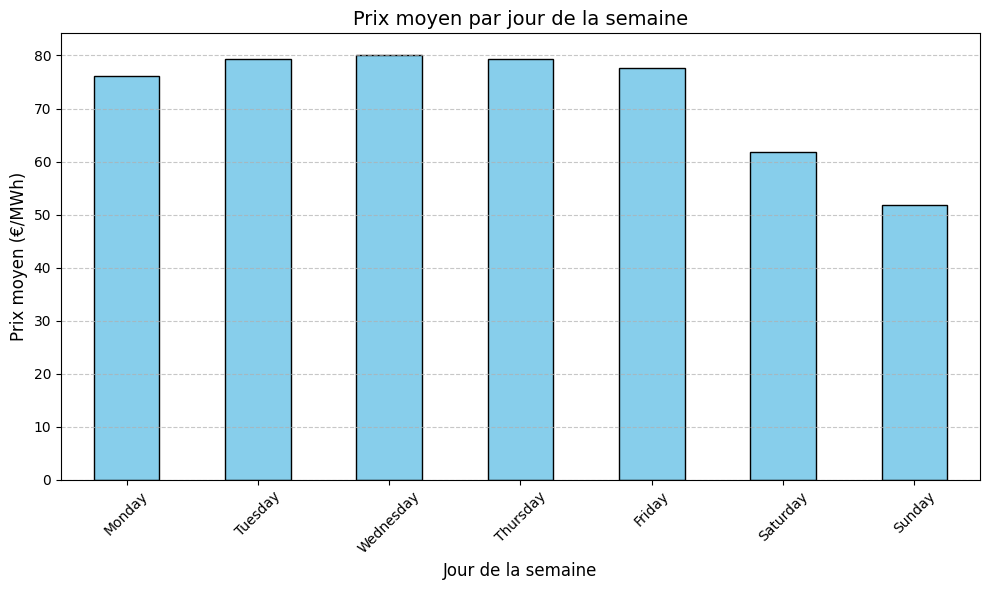

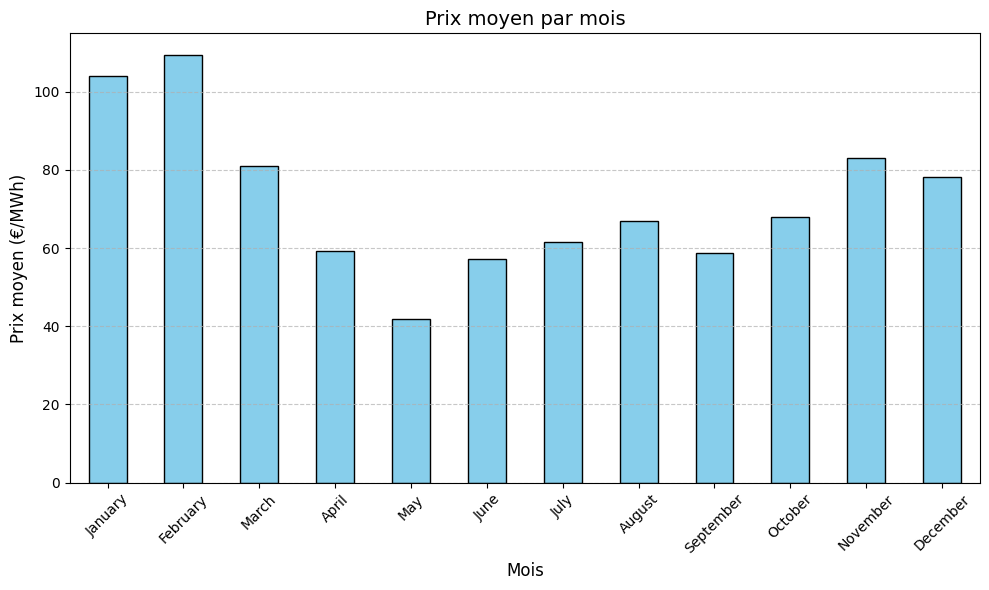

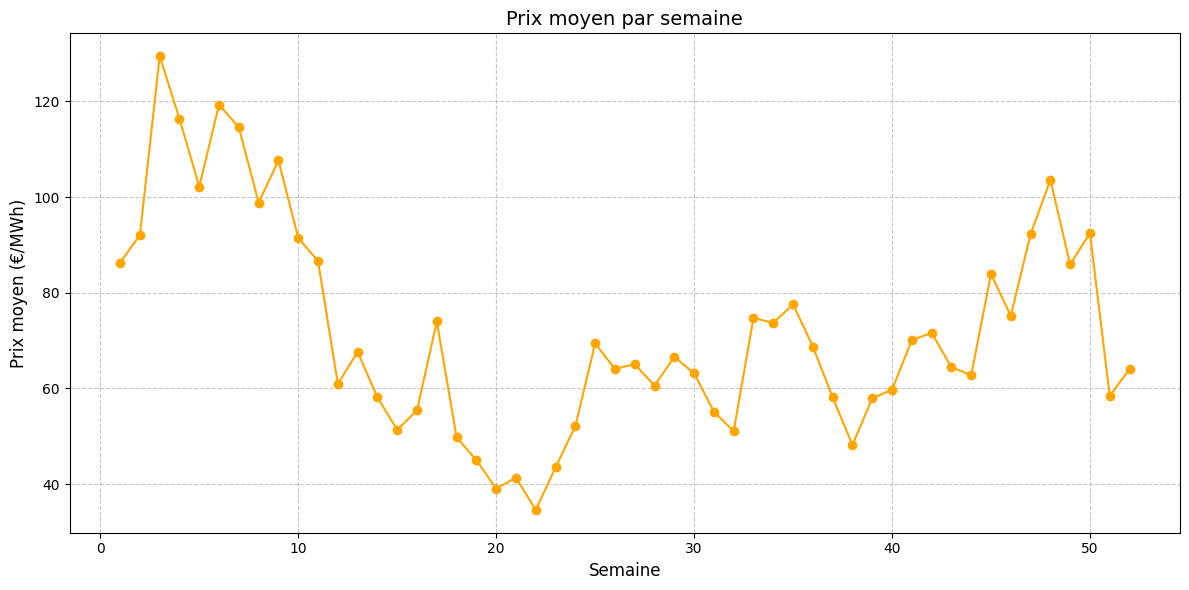

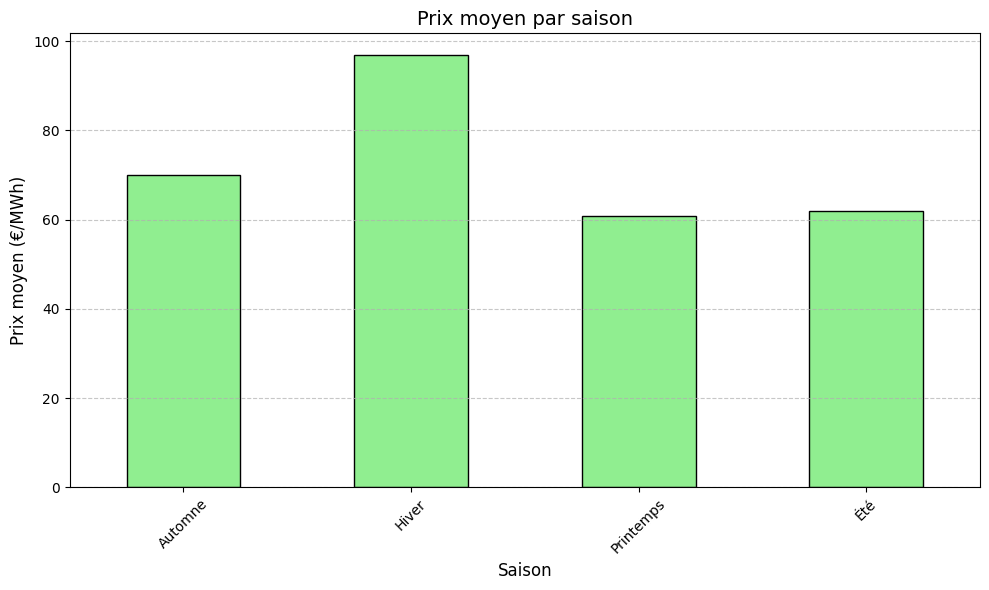

<Figure size 1200x800 with 0 Axes>

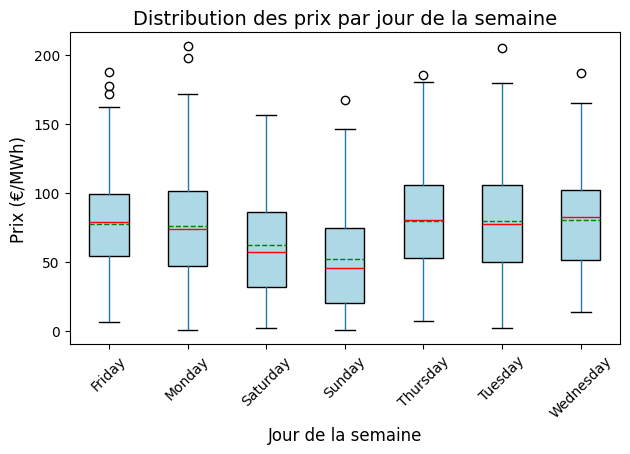

<Figure size 1200x800 with 0 Axes>

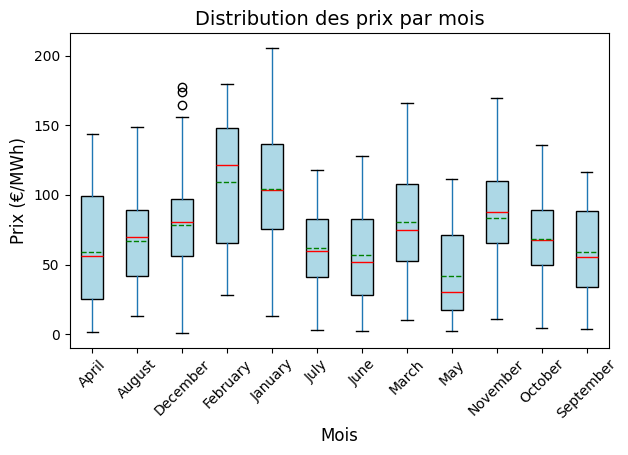

<Figure size 1200x800 with 0 Axes>

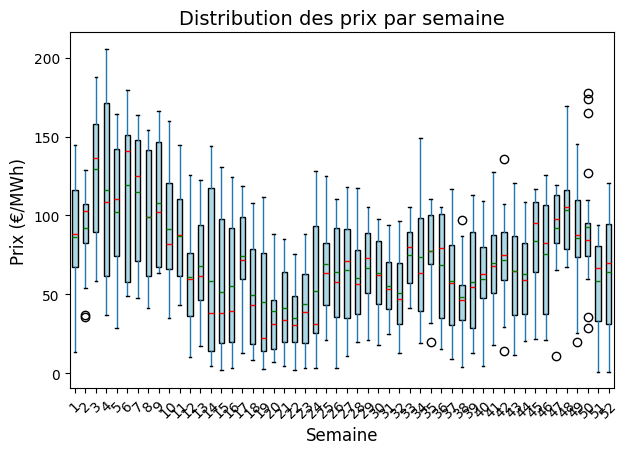

<Figure size 1200x800 with 0 Axes>

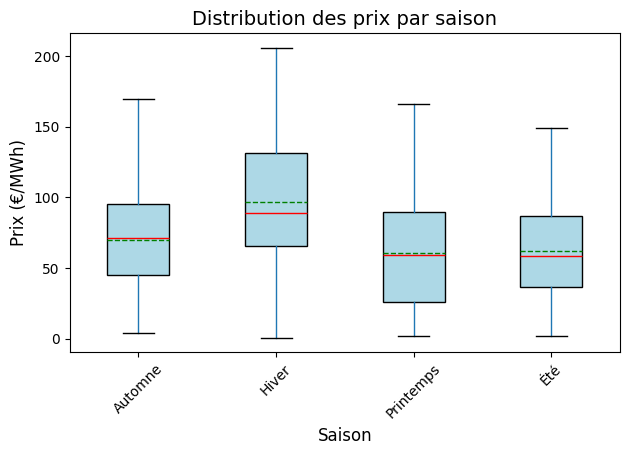

In [11]:
# Statistiques descriptives pour mesurer la saisonnalité par jour, mois, semaine et saison
stats_by_day = spot_merged.groupby('jour')['price'].describe()
stats_by_month = spot_merged.groupby('mois')['price'].describe()
stats_by_week = spot_merged.groupby('semaine')['price'].describe()
stats_by_season = spot_merged.groupby('saison')['price'].describe()

print("Statistiques descriptives par jour de la semaine:")
print(stats_by_day)
print("\nStatistiques descriptives par mois:")
print(stats_by_month)
print("\nStatistiques descriptives par semaine:")
print(stats_by_week)
print("\nStatistiques descriptives par saison:")
print(stats_by_season)

# Graphique de la moyenne des prix par jour de la semaine
plt.figure(figsize=(10, 6))
spot_merged.groupby('jour')['price'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par jour de la semaine", fontsize=14)
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par mois
plt.figure(figsize=(10, 6))
spot_merged.groupby('mois')['price'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'
]).plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Prix moyen par mois", fontsize=14)
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par semaine
plt.figure(figsize=(12, 6))
spot_merged.groupby('semaine')['price'].mean().plot(color='orange', linestyle='-', marker='o')
plt.title("Prix moyen par semaine", fontsize=14)
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la moyenne des prix par saison
plt.figure(figsize=(10, 6))
spot_merged.groupby('saison')['price'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Prix moyen par saison", fontsize=14)
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix moyen (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par jour de la semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='jour', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par jour de la semaine", fontsize=14)
plt.suptitle("")  # Supprimer le titre par défaut de boxplot
plt.xlabel("Jour de la semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par mois
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='mois', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par mois", fontsize=14)
plt.suptitle("")
plt.xlabel("Mois", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par semaine
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='semaine', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par semaine", fontsize=14)
plt.suptitle("")
plt.xlabel("Semaine", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Graphique de la distribution des prix par saison
plt.figure(figsize=(12, 8))
spot_merged.boxplot(column='price', by='saison', grid=False, showmeans=True, meanline=True,
                    patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'),
                    medianprops=dict(color='red'), meanprops=dict(color='green'))
plt.title("Distribution des prix par saison", fontsize=14)
plt.suptitle("")
plt.xlabel("Saison", fontsize=12)
plt.ylabel("Prix (€/MWh)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On calcule les log-prix et la position temporelle dans l'année

In [12]:
spot_merged['log_price'] = np.log(spot_merged['price'])
spot_merged['t_years'] = np.arange(len(spot_merged)) / 365

### 1. Désaisonnalisation et Filtrage (Méthode Benth et al. 2012)

Afin d'extraire la composante déterministe (saisonnalité + tendance) tout en évitant que les pics de prix extrêmes (*spikes*) ne biaisent l'estimation, nous suivons la méthodologie décrite par **Benth, Kiesel & Nazarova**. Contrairement à une simple série de Fourier, cette approche intègre une tendance linéaire et un pré-traitement des données.

#### A. Modèle de Tendance $\mu(t)$
La fonction de tendance retenue inclut une composante linéaire (pour capturer l'évolution structurelle des coûts) et deux harmoniques (annuelle et semi-annuelle) :

$$
\mu(t) = \alpha + \beta t + \gamma \cos(\epsilon + 2\pi t) + \delta \cos(\zeta + 4\pi t)
$$

Où :
* $\alpha$ : Niveau de base (coût fixe de production).
* $\beta t$ : Tendance linéaire à long terme (inflation, fuel switching).
* $\gamma, \epsilon$ : Amplitude et phase de la saisonnalité **annuelle** (12 mois).
* $\delta, \zeta$ : Amplitude et phase de la saisonnalité **semi-annuelle** (capture les variations hiver/été).

#### B. Algorithme de Calibration (Filtrage Préalable)
Les auteurs soulignent que la présence de *spikes* violents peut fausser l'estimation des moindres carrés. La procédure de calibration se fait donc en trois étapes :

1.  **Lissage :** Calcul d'une moyenne mobile centrée sur une fenêtre glissante de **30 jours**.
2.  **Filtrage des Outliers :** Si l'écart absolu entre le log-prix réel et la moyenne mobile dépasse un seuil de **0.5**, la valeur est considérée comme un *outlier* et remplacée par la moyenne lissée. Cette substitution est temporaire et sert uniquement à la calibration.
3.  **Estimation :** Les paramètres de $\mu(t)$ sont estimés sur cette série "nettoyée" via un ajustement aux moindres carrés non-linéaires (*Non-linear Least Squares*).

Une fois la tendance $\mu(t)$ calibrée, la série stochastique désaisonnalisée $X_t$ est obtenue en soustrayant la tendance aux **prix originaux** (en conservant les spikes) :

$$
X_t = \ln(S_t) - \mu(t)
$$

Préfiltrage

In [13]:
# Calcul de la moyenne mobile
window_size = 30
spot_merged['log_price_smooth'] = spot_merged['log_price'].rolling(
    window=window_size, center=True, min_periods=1
).mean()

# Remplacement des outliers pour la calibration
# On crée une série temporaire juste pour fitter la tendance
spot_merged['log_price_for_fit'] = spot_merged['log_price'].copy()

# Masque des outliers
outlier_mask = np.abs(spot_merged['log_price'] - spot_merged['log_price_smooth']) > 0.5
num_filtered = outlier_mask.sum()

# Remplacement
spot_merged.loc[outlier_mask, 'log_price_for_fit'] = spot_merged.loc[outlier_mask, 'log_price_smooth']

print(f"Filtrage Benth et al. : {num_filtered} points remplacés par la moyenne lissée.")

Filtrage Benth et al. : 259 points remplacés par la moyenne lissée.


In [14]:
# mu(t) = alpha + beta*t + gamma*cos(epsilon + 2*pi*t) + delta*cos(zeta + 4*pi*t)
def seasonality_func(t, alpha, beta, gamma, epsilon, delta, zeta):
    term1 = alpha + beta * t
    term2 = gamma * np.cos(epsilon + 2 * np.pi * t) # Saisonnalité annuelle
    term3 = delta * np.cos(zeta + 4 * np.pi * t)    # Saisonnalité semi-annuelle
    return term1 + term2 + term3

# On fit la fonction sur les données filtrées
p0_guess = [
    spot_merged['log_price'].mean(),
    0.0,
    0.5, 0.0,
    0.2, 0.0
]

# Optimisation
params_opt, params_cov = curve_fit(
    seasonality_func,
    spot_merged['t_years'].values,
    spot_merged['log_price_for_fit'].values,
    p0=p0_guess
)

alpha_fit, beta_fit, gamma_fit, eps_fit, delta_fit, zeta_fit = params_opt

print(f"Alpha : {alpha_fit:.4f}")
print(f"Beta   : {beta_fit:.4f}")
print(f"Gamma : {gamma_fit:.4f}")
print(f"Epsilon : {eps_fit:.4f}")
print(f"Delta : {delta_fit:.4f}")
print(f"Zeta : {zeta_fit:.4f}")


Alpha : 4.5526
Beta   : -0.2904
Gamma : 0.3926
Epsilon : 0.4209
Delta : 0.2167
Zeta : -1.0525


In [15]:
spot_merged['seasonality_trend'] = seasonality_func(
    spot_merged['t_years'].values, *params_opt
)
# On soustrait la tendance aux log-prix originaux
# Xt = log(St) - mu(t)
spot_merged['Xt'] = spot_merged['log_price'] - spot_merged['seasonality_trend']


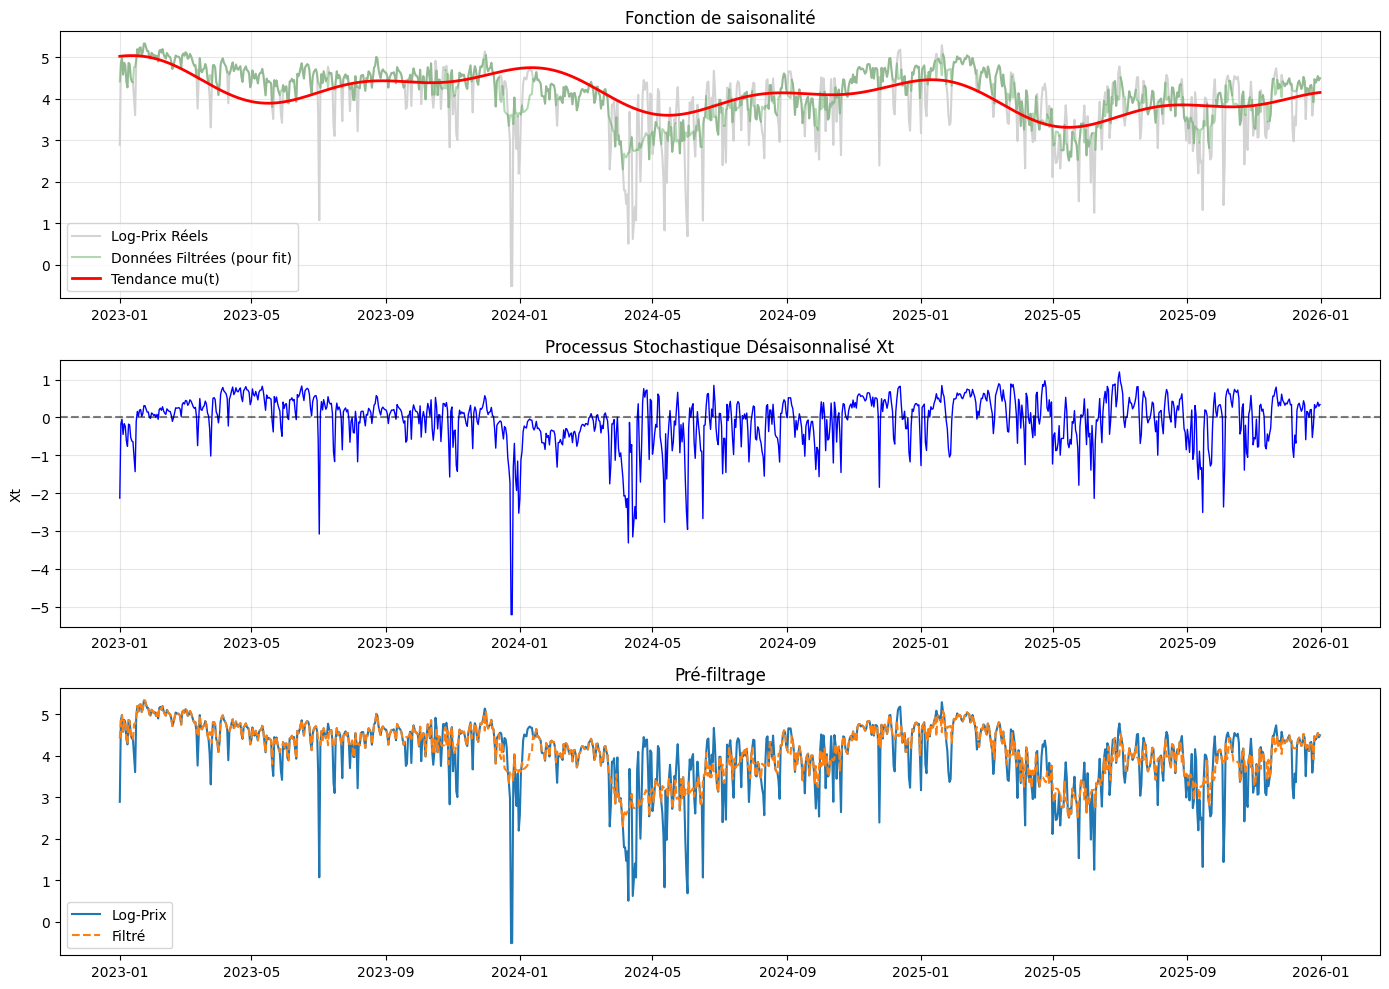

In [16]:
plt.figure(figsize=(14, 10))

# Prix originaux vs Tendance Estimée
plt.subplot(3, 1, 1)
plt.plot(spot_merged['date'], spot_merged['log_price'], color='lightgray', label='Log-Prix Réels')
plt.plot(spot_merged['date'], spot_merged['log_price_for_fit'], color='green', alpha=0.3, label='Données Filtrées (pour fit)')
plt.plot(spot_merged['date'], spot_merged['seasonality_trend'], color='red', linewidth=2, label='Tendance mu(t)')
plt.title("Fonction de saisonalité")
plt.legend()
plt.grid(True, alpha=0.3)

# Processus Désaisonnalisé Xt
plt.subplot(3, 1, 2)
plt.plot(spot_merged['date'], spot_merged['Xt'], color='blue', linewidth=1)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Processus Stochastique Désaisonnalisé Xt")
plt.ylabel("Xt")
plt.grid(True, alpha=0.3)

# filtrage
plt.subplot(3, 1, 3)
plt.plot(spot_merged['date'], spot_merged['log_price'], label='Log-Prix')
plt.plot(spot_merged['date'], spot_merged['log_price_for_fit'], label='Filtré', linestyle='--')
plt.title("Pré-filtrage")
plt.legend()

plt.tight_layout()
plt.show()

### 2. Détection et Filtrage des Sauts (Algorithme Récursif)

Une fois la composante saisonnière retirée, nous obtenons le processus stochastique $X_t$. Ce processus est modélisé comme une diffusion avec retour à la moyenne perturbée par des sauts (*Mean-Reverting Jump Diffusion*). Pour calibrer correctement les paramètres de la diffusion ($\alpha, \sigma$) sans qu'ils soient biaisés par les valeurs extrêmes, il est indispensable de séparer les sauts du "bruit normal".

Nous appliquons ici la méthode de filtrage itératif décrite par **Cartea & Figueroa (2005)** et reprise par **Benth et al. (2012)**.

#### Algorithme de détection :
Le principe repose sur la règle des "3-sigmas" appliquée récursivement :

1.  Calculer la moyenne $\mu$ et l'écart-type $\sigma$ des variations journalières de la série $X_t$.
2.  Identifier les points dont la variation absolue dépasse un seuil critique (fixé à **$3\sigma$**).
3.  Considérer ces points comme des **sauts** ($J$) et les retirer temporairement de l'échantillon.
4.  Répéter le calcul ($\mu, \sigma$) sur la série restante. Comme les valeurs extrêmes ont été retirées, l'écart-type diminue, ce qui permet de détecter des sauts plus petits lors de l'itération suivante.
5.  L'algorithme s'arrête lorsqu'aucun nouveau saut n'est détecté.

À l'issue de ce processus, nous obtenons deux jeux de données distincts :
* Une série **"nettoyée"** (la diffusion pure) pour estimer le retour à la moyenne $\alpha$ et la volatilité $\sigma$.
* Une série de **sauts** isolés pour estimer la fréquence de saut $l$ et la distribution des amplitudes ($\mu_J, \sigma_J$).

In [17]:
# Variations journalières du processus désaisonnalisé Xt
# dx_t correspond approximativement à X(t+1) - X(t)
dx = spot_merged['Xt'].diff().dropna()

clean_dx = dx.copy()
jumps_indices = []
iteration = 0
SIGMA_THRESHOLD = 3.0

while True:
    iteration += 1
    mu = clean_dx.mean()
    std = clean_dx.std()

    # Critère de détection : Variation > 3 * écart-type actuel
    # On utilise la valeur absolue
    is_jump = np.abs(clean_dx - mu) > SIGMA_THRESHOLD * std

    # Condition d'arrêt : Si aucun nouveau saut n'est trouvé, on stoppe
    if not is_jump.any():
        break

    # On sauvegarde les sauts trouvés
    new_jumps = clean_dx[is_jump]
    jumps_indices.extend(new_jumps.index)

    clean_dx = clean_dx[~is_jump]

# Résultats
print(f"Itérations : {iteration}")
print(f"Nombre total de sauts détectés : {len(jumps_indices)}")

# On marque les sauts dans le DataFrame principal pour usage futur
spot_merged['is_jump'] = False
spot_merged.loc[jumps_indices, 'is_jump'] = True

Itérations : 9
Nombre total de sauts détectés : 54


<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/2815471824.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(spot_merged.loc[jumps_indices, 'date'], dx[jumps_indices], color='red', marker='x', s=40, label='Sauts détectés (> 3$\sigma$)', zorder=5)
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/2815471824.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(threshold_up, color='green', linestyle='--', alpha=0.8, label=f'Seuil (+{SIGMA_THRESHOLD}$\sigma$)')
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/2815471824.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.axhline(threshold_down, color='green', linesty

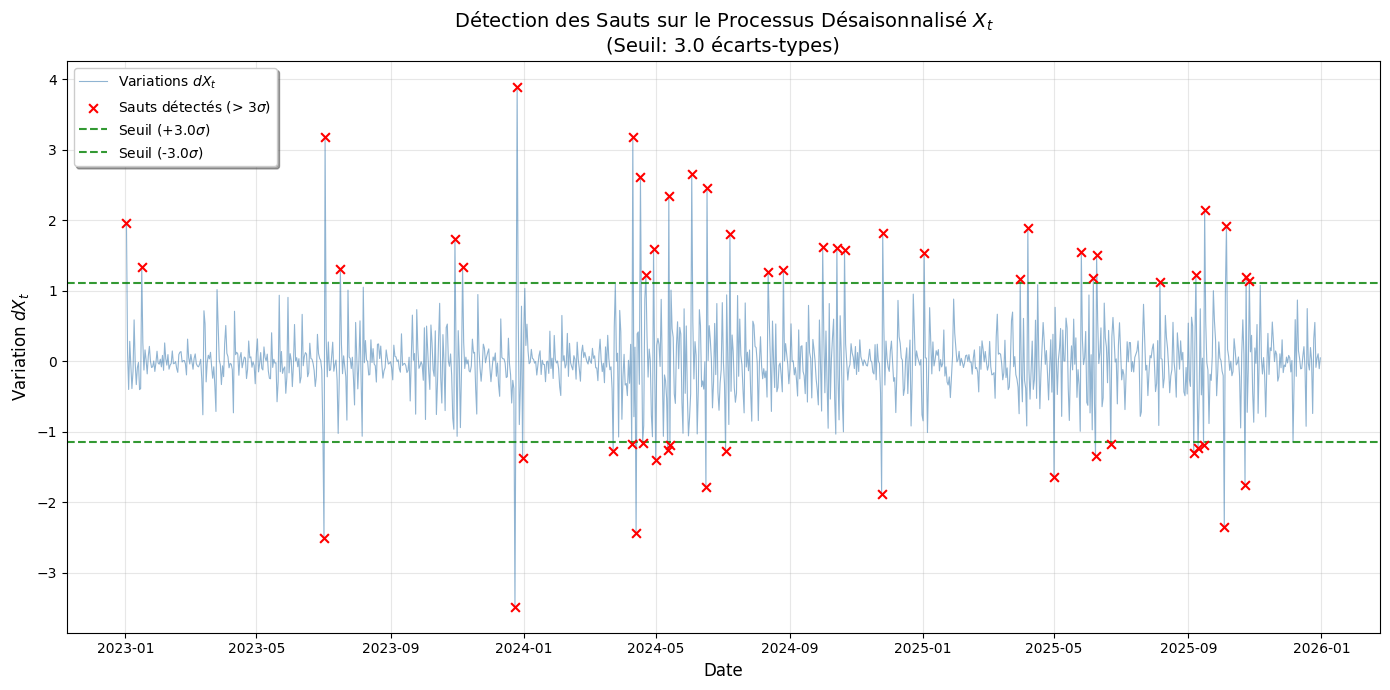

In [18]:
final_std = clean_dx.std()
final_mu = clean_dx.mean()
threshold_up = final_mu + SIGMA_THRESHOLD * final_std
threshold_down = final_mu - SIGMA_THRESHOLD * final_std

plt.figure(figsize=(14, 7))

plt.plot(spot_merged['date'].iloc[1:], dx,color='steelblue', alpha=0.6, linewidth=0.8, label='Variations $dX_t$')
plt.scatter(spot_merged.loc[jumps_indices, 'date'], dx[jumps_indices], color='red', marker='x', s=40, label='Sauts détectés (> 3$\sigma$)', zorder=5)
plt.axhline(threshold_up, color='green', linestyle='--', alpha=0.8, label=f'Seuil (+{SIGMA_THRESHOLD}$\sigma$)')
plt.axhline(threshold_down, color='green', linestyle='--', alpha=0.8, label=f'Seuil (-{SIGMA_THRESHOLD}$\sigma$)')

plt.title(f"Détection des Sauts sur le Processus Désaisonnalisé $X_t$\n(Seuil: {SIGMA_THRESHOLD} écarts-types)", fontsize=14)
plt.ylabel("Variation $dX_t$", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.legend(loc='upper left', frameon=True, shadow=True)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Nombre de sauts : 54
l : 18.00 sauts/an
Moyenne (Mu_J)     : 0.2327
Volatilité (Sigma_J): 1.8062


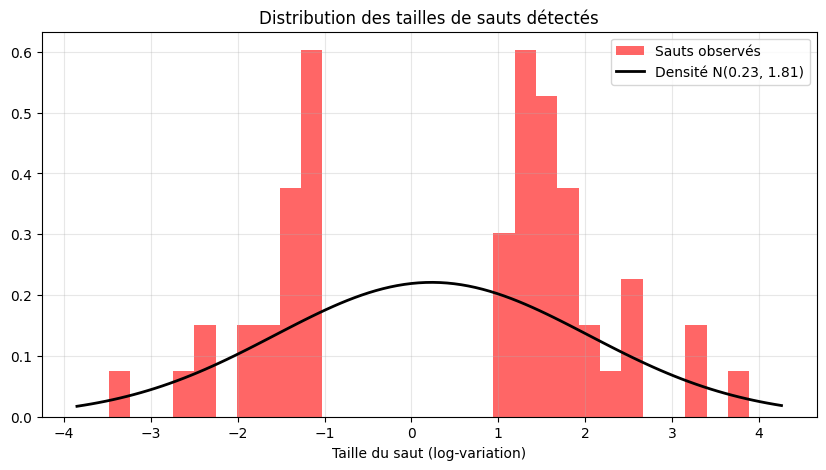

In [19]:
jump_values = dx.loc[jumps_indices]

mu_J = jump_values.mean()*0.5
sigma_J = jump_values.std()

nb_years = (spot_merged['date'].max() - spot_merged['date'].min()).days / 365
lambda_J = len(jump_values) / nb_years

print(f"Nombre de sauts : {len(jump_values)}")
print(f"l : {lambda_J:.2f} sauts/an")
print(f"Moyenne (Mu_J)     : {mu_J:.4f}")
print(f"Volatilité (Sigma_J): {sigma_J:.4f}")

# Visualisation de la distribution des sauts (Histogramme)
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.figure(figsize=(10, 5))
# Histogramme des sauts
count, bins, ignored = plt.hist(jump_values, 30, density=True, alpha=0.6, color='red', label='Sauts observés')

# Courbe théorique Normale
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu_J, sigma_J)
plt.plot(x, p, 'k', linewidth=2, label=f'Densité N({mu_J:.2f}, {sigma_J:.2f})')

plt.title("Distribution des tailles de sauts détectés")
plt.xlabel("Taille du saut (log-variation)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 3. Modélisation de la Volatilité $\sigma(t)$

La section 5.2.1 de Benth et al. (2012) critique l'hypothèse de volatilité constante ou purement historique. Les marchés de l'électricité présentent une structure de volatilité complexe :
1.  **Saisonnalité :** La volatilité est souvent plus élevée en hiver (tensions sur la demande pour le chauffage) ou en été (canicule et climatisation).
2.  **Clustering :** Les périodes de forte agitation ont tendance à se regrouper (effet de persistance).

Cartea et Figueroa suggèrent d'utiliser une volatilité dépendante du temps. Nous calculons d'abord la **volatilité historique glissante** (*Rolling Historical Volatility*) sur une fenêtre de 30 jours, telle que suggérée par Eydeland et Wolyniec (2002).

Cependant, comme le souligne Benth et al. (voir Fig. 3 de leur papier), cette volatilité historique présente un motif saisonnier clair qu'il convient de modéliser pour les simulations futures. Nous ajustons donc une fonction déterministe $\sigma(t)$ définie par une série de Fourier tronquée :

$$
\sigma(t) = a + b \cos(2\pi t + c) + d \cos(4\pi t)
$$

Où :
* **$a$** : Niveau moyen de la volatilité annuelle (le "bruit de fond").
* **$b, c$** : Amplitude et phase de la saisonnalité **annuelle** (pic principal hivernal).
* **$d$** : Amplitude de la saisonnalité **semi-annuelle** (permettant de capturer un second pic potentiel en été ou d'ajuster la forme du pic hivernal).

Cette fonction lissée $\sigma(t)$ sera celle injectée dans le processus de diffusion lors de la phase de pricing Monte Carlo.

Volatilité moyenne calibrée : 688.64%
a : 6.8863684213982586 
b : -1.353929374619674 
c : 5.673931375122613 
d : 0.4784428923143418 


<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:37: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/1340689699.py:35: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(spot_merged['date'], vol_fitted, color='red', linewidth=2, alpha=0.8, label='Modèle Saisonnier $\sigma(t)$')
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/1340689699.py:37: SyntaxWarning: invalid escape sequence '\s'
  plt.title("Dynamique de la Volatilité $\sigma(t)$ (Diffusion sans sauts)")


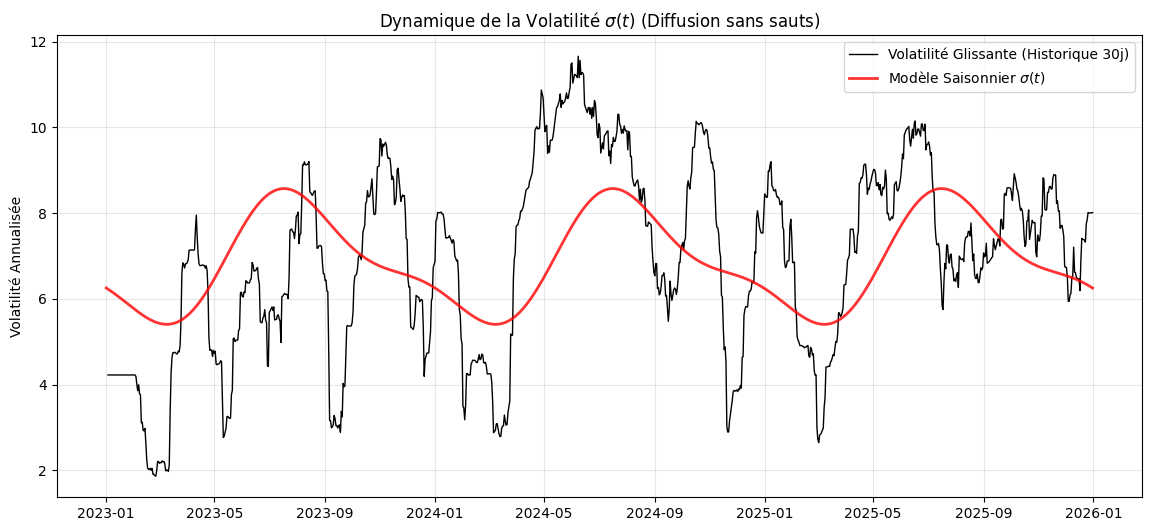

In [20]:
# Calcul de la Volatilité Glissante
# clean_dx a des trous (sauts retirés).
WINDOW_VOL = 30
vol_rolling = clean_dx.rolling(window=WINDOW_VOL).std() * np.sqrt(365)
vol_rolling = vol_rolling.bfill()

# Modélisation Saisonnière
def vol_seasonality_func(t, a, b, c, d):
    return a + b * np.cos(2 * np.pi * t + c) + d * np.cos(4 * np.pi * t)

# Fit sur les données disponibles
from scipy.optimize import curve_fit
valid_vol_idx = ~np.isnan(vol_rolling)
# On récupère les temps t correspondant aux indices restants dans vol_rolling
t_vol = spot_merged.loc[vol_rolling.index, 't_years'][valid_vol_idx]
y_vol = vol_rolling[valid_vol_idx]

# Calibration
p0=[0.5, 0.2, 0.0, 0.1]
popt_vol, _ = curve_fit(vol_seasonality_func, t_vol.values, y_vol.values, p0, maxfev=5000)

vol_fitted = vol_seasonality_func(spot_merged['t_years'].values, *popt_vol)
print(f"Volatilité moyenne calibrée : {popt_vol[0]:.2%}")

print(f"a : {popt_vol[0]} ")
print(f"b : {popt_vol[1]} ")
print(f"c : {popt_vol[2]} ")
print(f"d : {popt_vol[3]} ")

plt.figure(figsize=(14, 6))

dates_for_rolling = spot_merged.loc[vol_rolling.index, 'date']

plt.plot(dates_for_rolling, vol_rolling, color='black', linewidth=1, label='Volatilité Glissante (Historique 30j)')
plt.plot(spot_merged['date'], vol_fitted, color='red', linewidth=2, alpha=0.8, label='Modèle Saisonnier $\sigma(t)$')

plt.title("Dynamique de la Volatilité $\sigma(t)$ (Diffusion sans sauts)")
plt.ylabel("Volatilité Annualisée")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

spot_merged['sigma_t'] = vol_fitted

### 4. Calibration du Retour à la Moyenne ($\alpha$)

Nous calibrons le paramètre de retour à la moyenne $\alpha$ en suivant l'approche de **Cartea & Figueroa (2005)** (Équation 16). Une régression linéaire est effectuée sur la série désaisonnalisée $X_t$ complète :

$$X_t = \beta X_{t-1} + \epsilon_t$$

Dans cette spécification, le terme d'erreur $\epsilon_t$ capture à la fois la diffusion (mouvement brownien) et les sauts. Le paramètre est ensuite déduit par $\alpha = -\ln(\beta)$.

In [21]:
df_reg = pd.DataFrame({'Xt': spot_merged['Xt'], 'Xt_1': spot_merged['Xt'].shift(1)}).dropna()

reg = LinearRegression(fit_intercept=False).fit(df_reg[['Xt_1']], df_reg['Xt'])
beta= reg.coef_[0]
alpha = -np.log(beta)

print(f"Alpha (mean-reversion) : {alpha:.4f}")
print(f"Demi-vie : {np.log(2)/alpha:.4f}")

Alpha (mean-reversion) : 0.4094
Demi-vie : 1.6929


<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\s'
<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:77: SyntaxWarning: invalid escape sequence '\s'
<>:83: SyntaxWarning: invalid escape sequence '\s'
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/271931570.py:75: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(future_dates, np.exp(mu_t_future), color='red', linestyle='--', label='Tendance Saisonnière $\mu(t)$')
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/271931570.py:77: SyntaxWarning: invalid escape sequence '\s'
  ax1.set_title("Simulation avec Volatilité Saisonnière $\sigma(t)$")
/var/folders/d3/08gxms8j7zq9sxn5lh0v48s80000gn/T/ipykernel_1518/271931570.py:83: SyntaxWarning: invalid escape sequence '\s'
  ax2.plot(future_dates, sigma_t_future, color='orange', linestyle=':', alpha=0.7, label='Volatilité $\sigma(t)$')


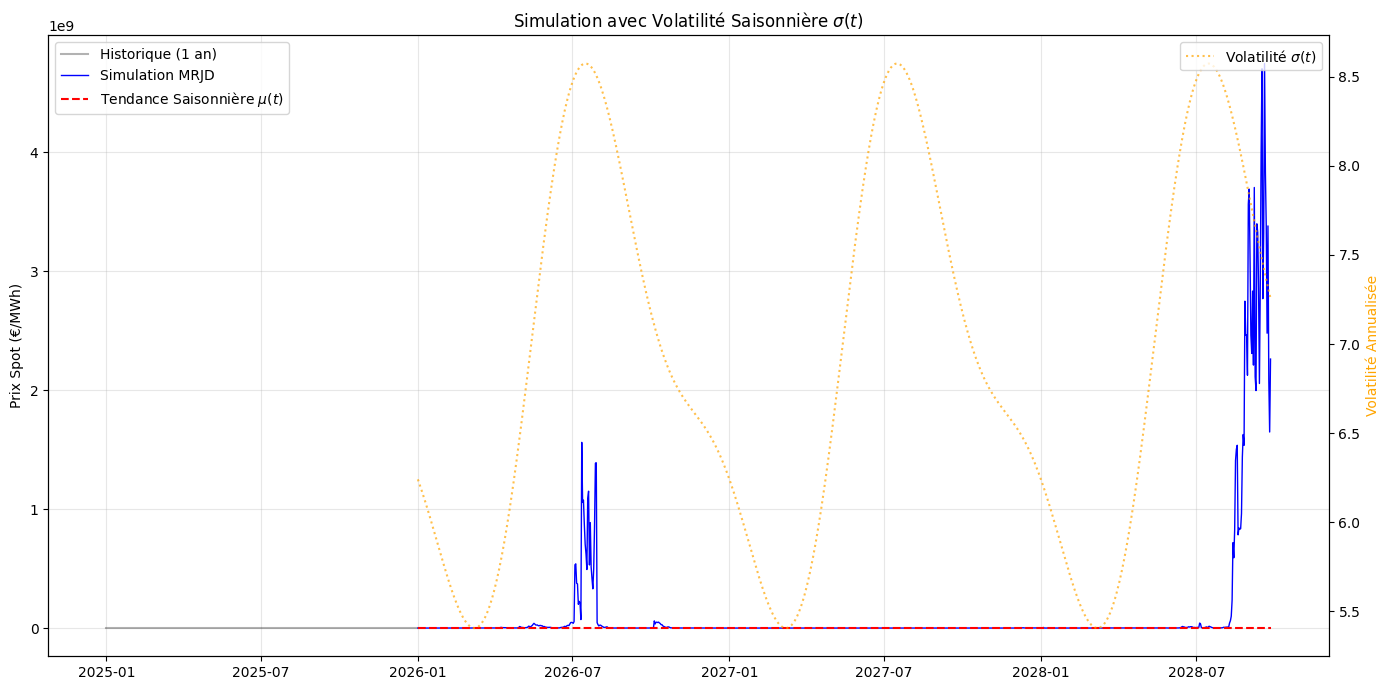

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================================
# 1. PARAMÈTRES DE SIMULATION
# ==============================================================================
N_SIM = 1           # Nombre de trajectoires
HORIZON_DAYS = 1000 # Horizon de prévision
DT = 1 / 365    # Pas de temps annuel

# Initialisation temporelle
last_date = spot_merged['date'].iloc[-1]
last_Xt = spot_merged['Xt'].iloc[-1]
last_t_year = spot_merged['t_years'].iloc[-1]

# Création des vecteurs temps futurs
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=HORIZON_DAYS)
future_t_years = np.linspace(last_t_year + DT, last_t_year + HORIZON_DAYS*DT, HORIZON_DAYS)

# ==============================================================================
# 2. PROJECTION DES FONCTIONS DÉTERMINISTES
# ==============================================================================

# A. Projection de la Saisonnalité des Prix mu(t)
# (Utilise la fonction et les params de l'étape 1)
mu_t_future = seasonality_func(future_t_years, *params_opt)

# B. Projection de la Volatilité sigma(t) (VOTRE FONCTION)
def vol_seasonality_func(t, a, b, c, d):
    return a + b * np.cos(2 * np.pi * t + c) + d * np.cos(4 * np.pi * t)

# On utilise vos paramètres calibrés 'popt_vol'
sigma_t_future = vol_seasonality_func(future_t_years, *popt_vol)

# Boucle de simulation
Xt_sim = np.zeros(HORIZON_DAYS)
current_x = last_Xt

# Pré-calcul des termes constants de l'OU
exp_alpha = np.exp(-alpha * DT)
variance_factor_base = np.sqrt((1 - np.exp(-2*alpha*DT)) / (2*alpha))

# Génération des aléas
Z = np.random.normal(0, 1, HORIZON_DAYS)
is_jump = np.random.uniform(0, 1, HORIZON_DAYS) < (lambda_J * DT)
jump_sizes = np.random.normal(mu_J, sigma_J, HORIZON_DAYS) * is_jump

for t in range(HORIZON_DAYS):
    # 1. Volatilité locale à l'instant t
    sigma_local = sigma_t_future[t]

    # 2. Diffusion OU (Mean Reverting)
    # La volatilité stochastique s'applique au terme brownien
    diffusion_term = sigma_local * variance_factor_base * Z[t]

    diffusion = current_x * exp_alpha + diffusion_term

    # 3. Sauts
    current_x = diffusion + jump_sizes[t]

    Xt_sim[t] = current_x

# ==============================================================================
# 4. RECONSTRUCTION ET VISUALISATION
# ==============================================================================
# St = exp(Xt + mu(t))
St_sim = np.exp(Xt_sim + mu_t_future)

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Prix
ax1.plot(spot_merged['date'].iloc[-365:], spot_merged['price'].iloc[-365:], color='black', alpha=0.3, label='Historique (1 an)')
ax1.plot(future_dates, St_sim, color='blue', linewidth=1, label='Simulation MRJD')
ax1.plot(future_dates, np.exp(mu_t_future), color='red', linestyle='--', label='Tendance Saisonnière $\mu(t)$')
ax1.set_ylabel("Prix Spot (€/MWh)")
ax1.set_title("Simulation avec Volatilité Saisonnière $\sigma(t)$")
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot Volatilité (Axe droite)
ax2 = ax1.twinx()
ax2.plot(future_dates, sigma_t_future, color='orange', linestyle=':', alpha=0.7, label='Volatilité $\sigma(t)$')
ax2.set_ylabel("Volatilité Annualisée", color='orange')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
# --- ÉTAPE A : COURBE FORWARD 2026 ---
# Mapping des mois Baseload France 2026 (G=Fev, H=Mar...)
mapping_2026 = {
    'TRFRBFVMG6': 2, 'TRFRBFVMH6': 3, 'TRFRBFVMJ6': 4, 'TRFRBFVMK6': 5,
    'TRFRBFVMM6': 6, 'TRFRBFVMN6': 7, 'TRFRBFVMQ6': 8, 'TRFRBFVMU6': 9,
    'TRFRBFVMV6': 10, 'TRFRBFVMX6': 11, 'TRFRBFVMZ6': 12
}

# On prend la dernière ligne de prix du fichier futures
last_row = future.iloc[-1]
dates_2026 = pd.date_range('2026-02-01', '2026-12-31', freq='D')
fwd_curve_2026 = pd.Series(index=dates_2026, dtype=float)

for code, month in mapping_2026.items():
    fwd_curve_2026[fwd_curve_2026.index.month == month] = last_row[code]

# Lissage de la courbe pour éviter les sauts brutaux entre les mois
fwd_values_2026 = fwd_curve_2026.ffill().bfill().values
print("Courbe Forward 2026 construite.")

Courbe Forward 2026 construite.


# II. Valorisation du Swing

### Définition du Swing : (LSMC)

In [92]:
class SwingContract:
    def __init__(self, start_date, n_days, strike, min_daily=0, max_daily=1, min_annual=50, max_annual=250):
        self.start_date = start_date
        self.n_days = n_days
        self.strike = strike
        self.min_daily = min_daily
        self.max_daily = max_daily
        self.min_annual = min_annual
        self.max_annual = max_annual
        
def value_swing_option(contract, price_paths, discount_rate=0.04):
    """
    Valorisation LSMC retournant le prix, les bétas et la grille de volumes.
    """
    n_paths, n_steps = price_paths.shape 
    dt = 1/365
    df = np.exp(-discount_rate * dt)
    
    # Grille de volume cumulé Q (variable d'état)
    volumes = np.linspace(0, contract.max_annual, 20)
    n_vols = len(volumes)
    values = np.zeros((n_paths, n_vols))
    
    # --- AJOUT : Initialisation du stockage des bétas ---
    # Liste qui contiendra une matrice (n_vols x 3) pour chaque pas de temps t
    stored_betas = [] 
    
    # 1. Pénalité Terminale (Take-or-Pay) à t=T
    penalty_price = 1000 
    under_min = volumes < contract.min_annual
    values[:, under_min] = -penalty_price * (contract.min_annual - volumes[under_min])
    
    possible_q = [contract.min_daily, contract.max_daily] 
    
    # 2. Induction Arrière (Backward Induction)
    for t in range(n_steps - 1, -1, -1):
        prices = price_paths[:, t]
        # Base de régression : [1, S, S^2]
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        
        continuation_surface = np.zeros((n_paths, n_vols))
        # On crée une matrice pour stocker les 3 coefficients pour chaque point de volume
        step_betas = np.zeros((n_vols, 3)) 
        
        for v_idx in range(n_vols):
            y = values[:, v_idx] * df
            # Calcul des bétas par moindres carrés
            beta, _, _, _ = np.linalg.lstsq(P_basis, y, rcond=None)
            
            # --- STOCKAGE : On enregistre le cerveau du modèle à (t, v) ---
            step_betas[v_idx, :] = beta
            continuation_surface[:, v_idx] = P_basis @ beta
        
        # On ajoute les bétas de ce jour à la liste globale
        stored_betas.append(step_betas)
        
        new_values = np.full((n_paths, n_vols), -1e9)
        payoff_per_unit = prices - contract.strike
        
        for v_idx, v in enumerate(volumes):
            for q in possible_q:
                v_next = v + q
                if v_next > contract.max_annual: continue
                
                idx = np.searchsorted(volumes, v_next) - 1
                idx = np.clip(idx, 0, n_vols - 2)
                dist = volumes[idx+1] - volumes[idx]
                w = (v_next - volumes[idx]) / dist if dist > 0 else 0
                
                val_future = (1-w) * continuation_surface[:, idx] + w * continuation_surface[:, idx+1]
                total_val = (q * payoff_per_unit) + val_future
                new_values[:, v_idx] = np.maximum(new_values[:, v_idx], total_val)
        
        values = new_values

    # On inverse la liste des bétas pour qu'ils soient dans l'ordre chronologique (0 -> T-1)
    stored_betas.reverse()
    
    # On retourne le triplet nécessaire au check forward
    return np.mean(values[:, 0]), stored_betas, volumes

### Simulation MC Cartea & Figueroa (2005)

In [93]:
def simulate_final_paths(n_paths, n_days, fwd_curve, alpha_ann, sigma_d, lam_ann, mu_j, sigma_j, price_cap=4000):
    dt = 1/365.25
    paths = np.zeros((n_paths, n_days))
    paths[:, 0] = fwd_curve[0]
    x = np.zeros(n_paths)
    
    for t in range(1, n_days):
        z = np.random.normal(0, 1, n_paths)
        has_jump = np.random.rand(n_paths) < (lam_ann * dt)
        jumps = has_jump * np.random.normal(mu_j, sigma_j, n_paths)
        
        # Évolution du résidu log (Ornstein-Uhlenbeck + Sauts)
        x = x * np.exp(-alpha_ann * dt) + sigma_d * z + jumps
        
        # --- L'AJUSTEMENT DE MARTINGALE ---
        # On calcule l'écart moyen créé par les sauts et la volatilité
        adjustment = np.log(np.mean(np.exp(x)))
        
        # --- CALCUL DU PRIX ET APPLICATION DU CAP ---
        # On calcule les prix bruts
        raw_prices = fwd_curve[t] * np.exp(x - adjustment)
        
        # On écrête les valeurs au-dessus du plafond réglementaire (ex: 4000€)
        paths[:, t] = np.minimum(raw_prices, price_cap)
        
    return paths

### Résultats

In [94]:
# --- CELLULE FINALE : VALORISATION OFFICIELLE ---

# 1. Définition des paramètres de calibration (issus de tes cellules précédentes)
alpha_annuel = alpha / dt #
sigma_d = current_series.std() #
lam_ann = lambda_jump #
n_paths = 10000
# 2. Création du contrat avec ta classe SwingContract
mon_contrat = SwingContract(
    start_date='2026-02-01',
    n_days=len(fwd_values_2026),
    strike=fwd_values_2026.mean(),
    min_daily=0,
    max_daily=1,
    min_annual=50,
    max_annual=250
)

# 3. Simulation des trajectoires (Méthode Cartea & Figueroa)
# Assure-toi d'utiliser la fonction simulate_final_paths avec ajustement
paths_2026 = simulate_final_paths(
    n_paths, len(fwd_values_2026), fwd_values_2026,
    alpha_annuel, sigma_d, lam_ann, mu_jump, sigma_jump
)

# 4. Calcul de la valeur avec la Méthode 2 (Interpolée)
# On récupère le prix, le "cerveau" (betas) et la grille de volumes
prix_final, model_betas, volume_grid = value_swing_option(contract_2026, paths_2026)


print(f"VALEUR DU SWING (MÉTHODE INTERPOLÉE) : {prix_final:.2f} EUR")




NameError: name 'contract_2026' is not defined

In [960]:
# Vérification de l'absence d'arbitrage
mean_simulated_price = paths_2026.mean(axis=0)
error = np.mean(mean_simulated_price - fwd_values_2026)
print(f"Erreur moyenne par rapport aux Futures : {error:.4f} EUR")
print("Provient du cap à 4000")

Erreur moyenne par rapport aux Futures : -7.7050 EUR
Provient du cap à 4000


In [968]:
def calculate_swing_greeks(contract, base_params, fwd_curve, n_paths=1000):
    """
    Calcule les Grecques (Delta, Vega) par 'Bump and Re-price' et estime le Theta.
    """
    # 1. Prix de Référence (V0)
    # Note : on utilise mu_jump défini globalement ou passé en paramètre
    paths_ref = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                    base_params['alpha'], base_params['sigma_d'], 
                                    base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v0, _, _ = value_swing_option(contract, paths_ref)

    # --- DELTA ---
    fwd_up = fwd_curve + 1.0
    paths_up = simulate_final_paths(n_paths, len(fwd_curve), fwd_up, 
                                   base_params['alpha'], base_params['sigma_d'], 
                                   base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe le triplet
    v_delta, _, _ = value_swing_option(contract, paths_up)
    delta = v_delta - v0

    # --- VEGA ---
    sigma_up = base_params['sigma_d'] + 0.01
    paths_vega = simulate_final_paths(n_paths, len(fwd_curve), fwd_curve, 
                                     base_params['alpha'], sigma_up, 
                                     base_params['lambda'], mu_jump, base_params['sigma_j'])
    
    # Correction : on déballe pour récupérer v_vega avant le calcul
    v_vega, _, _ = value_swing_option(contract, paths_vega)
    vega = (v_vega - v0) / 0.01

    # --- THETA ESTIMÉ ---
    theta_est = -v0 / len(fwd_curve)

    return {'Delta': delta, 'Vega': vega, 'Theta': theta_est}


    # Préparation des paramètres de base
base_p = {
    'alpha': alpha_annuel, 
    'sigma_d': current_series.std(), 
    'lambda': lambda_jump, 
    'sigma_j': sigma_jump
}

# Calcul
greeks = calculate_swing_greeks(contract_2026, base_p, fwd_values_2026)

print(f"--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---")
print(f"Delta : {greeks['Delta']:.2f} EUR")
print(f"Vega  : {greeks['Vega']:.2f} EUR")
print(f"Theta : {greeks['Theta']:.2f} EUR/jour") #Théta éstimé

--- RÉSULTATS DES GRECQUES (CARTEA & FIGUEROA) ---
Delta : 152.83 EUR
Vega  : -11858.81 EUR
Theta : -27.73 EUR/jour


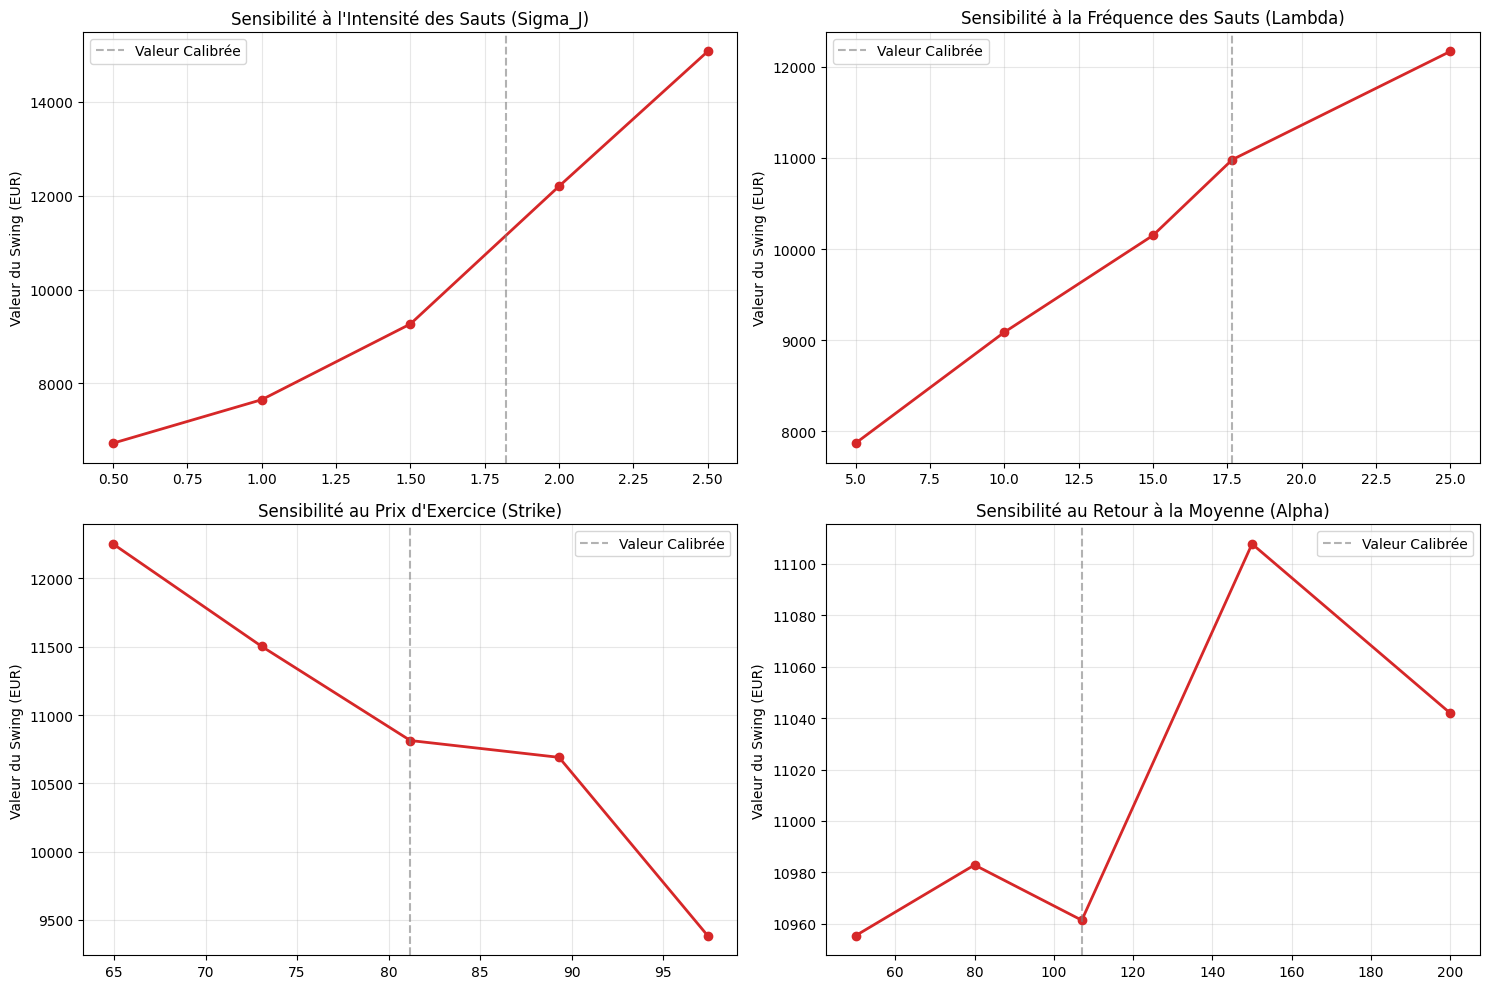

In [961]:
import matplotlib.pyplot as plt

def generate_all_sensitivities(base_params, contract, fwd_curve):
    """
    Génère les graphiques de sensibilité pour les 4 paramètres clés.
    """
    # 1. Définition des plages de test
    test_ranges = {
        'sigma_jump': np.linspace(0.5, 2.5, 5),   # Intensité des spikes
        'lambda_jump': [5, 10, 15, 17.67, 25],   # Fréquence des spikes/an
        'strike': [contract.strike * r for r in [0.8, 0.9, 1.0, 1.1, 1.2]], # Strike +/- 20%
        'alpha': [50, 80, 107.06, 150, 200]       # Vitesse de retour à la moyenne
    }
    
    titles = {
        'sigma_jump': "Sensibilité à l'Intensité des Sauts (Sigma_J)",
        'lambda_jump': "Sensibilité à la Fréquence des Sauts (Lambda)",
        'strike': "Sensibilité au Prix d'Exercice (Strike)",
        'alpha': "Sensibilité au Retour à la Moyenne (Alpha)"
    }

    plt.figure(figsize=(15, 10))
    
    for i, (param, values) in enumerate(test_ranges.items(), 1):
        prices = []
        for val in values:
            # Copie des paramètres et modification du paramètre cible
            current_p = base_params.copy()
            
            # Cas particulier pour le strike qui est dans l'objet contract
            if param == 'strike':
                test_contract = SwingContract(
                    contract.start_date, contract.n_days, val, 
                    contract.min_daily, contract.max_daily, 
                    contract.min_annual, contract.max_annual
                )
            else:
                current_p[param] = val
                test_contract = contract
            
            # Simulation et Pricing
            paths = simulate_paths_final(
                500, len(fwd_curve), fwd_curve, 
                current_p['sigma_daily'], current_p['lambda_jump'], 
                mu_jump, current_p['sigma_jump']
            )
            res_price, _, _ = value_swing_option(test_contract, paths)
            prices.append(res_price)
        
        # Plotting
        plt.subplot(2, 2, i)
        plt.plot(values, prices, 'o-', color='tab:red', linewidth=2)
        
        # Ajout de la valeur calibrée comme repère
        calibrated_val = base_params.get(param, contract.strike if param == 'strike' else None)
        if calibrated_val:
            plt.axvline(calibrated_val, color='gray', linestyle='--', alpha=0.6, label='Valeur Calibrée')
            
        plt.title(titles[param])
        plt.ylabel("Valeur du Swing (EUR)")
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# Assurez-vous que base_params contient vos valeurs : alpha, sigma_daily, lambda_jump, sigma_jump
base_parameters = {
    'alpha': alpha_annuel, # Votre 107.06
    'sigma_daily': current_series.std(),
    'lambda_jump': lambda_jump, # Votre 17.67
    'sigma_jump': sigma_jump # Votre 1.82
}

generate_all_sensitivities(base_parameters, contract_2026, fwd_values_2026)

/var/folders/yt/1z147f8d05q9s7xr6xd0ybg40000gn/T/ipykernel_15429/929770086.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


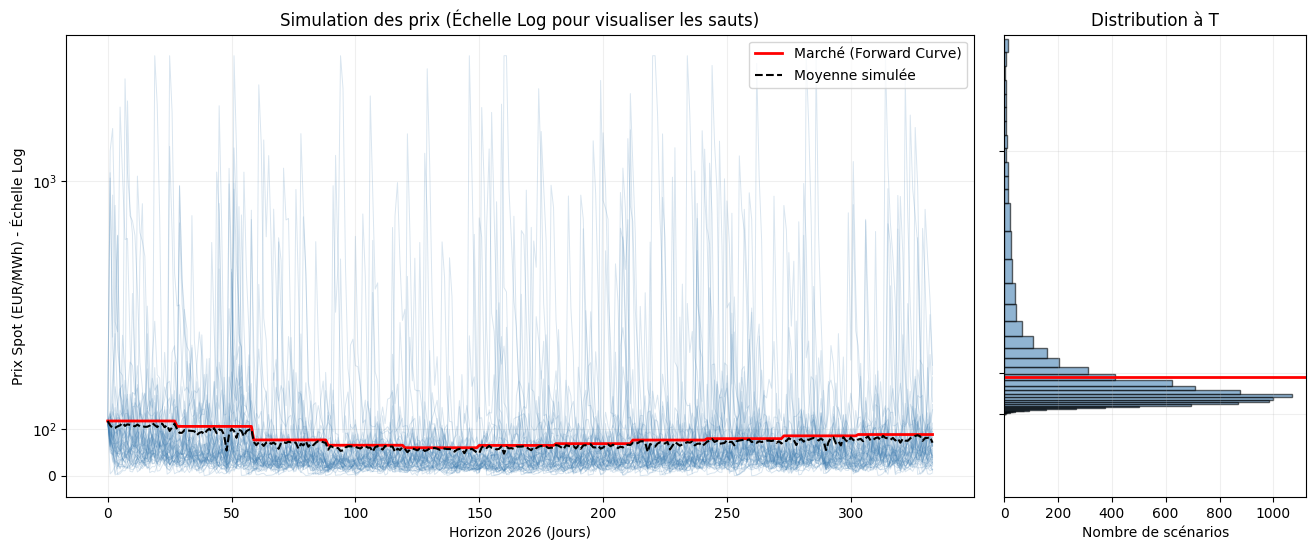

In [963]:
import matplotlib.pyplot as plt
import numpy as np

def plot_log_paths_and_distribution(paths, fwd_curve, n_paths_to_plot=50):
    """
    Affiche les trajectoires et la distribution finale en échelle Log
    pour mieux visualiser les sauts de Cartea & Figueroa.
    """
    n_days = paths.shape[1]
    days = np.arange(n_days)
    final_prices = paths[:, -1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), 
                                   gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.05})

    # --- PANEL 1 : TRAJECTOIRES (ÉCHELLE LOG) ---
    for i in range(min(n_paths_to_plot, len(paths))):
        ax1.plot(days, paths[i, :], color='steelblue', alpha=0.2, linewidth=0.7)
    
    ax1.plot(days, fwd_curve, color='red', linewidth=2, label='Marché (Forward Curve)')
    ax1.plot(days, np.mean(paths, axis=0), color='black', linestyle='--', label='Moyenne simulée')

    # Utilisation de symlog pour l'axe Y
    ax1.set_yscale('symlog', linthresh=500) # Linéaire jusqu'à 500, log au-delà
    ax1.set_title("Simulation des prix (Échelle Log pour visualiser les sauts)")
    ax1.set_xlabel("Horizon 2026 (Jours)")
    ax1.set_ylabel("Prix Spot (EUR/MWh) - Échelle Log")
    ax1.grid(True, which="both", alpha=0.2)
    ax1.legend()

    # --- PANEL 2 : DISTRIBUTION FINALE (LOG BINS) ---
    # On crée des bins logarithmiques pour l'histogramme
    bins = np.logspace(np.log10(max(1, np.min(final_prices))), 
                       np.log10(np.max(final_prices)), 50)
    
    ax2.hist(final_prices, bins=bins, orientation='horizontal', 
             color='steelblue', alpha=0.6, edgecolor='black')
    
    ax2.axhline(fwd_curve[-1], color='red', linewidth=2)
    ax2.set_yscale('symlog', linthresh=500) # Même échelle que le graphique de gauche
    ax2.set_title("Distribution à T")
    ax2.set_xlabel("Nombre de scénarios")
    ax2.set_yticklabels([]) 
    ax2.grid(True, which="both", alpha=0.2)

    plt.tight_layout()
    plt.show()

# --- EXÉCUTION ---
# paths_2026 doit être votre matrice de simulation
plot_log_paths_and_distribution(paths_2026, fwd_values_2026)

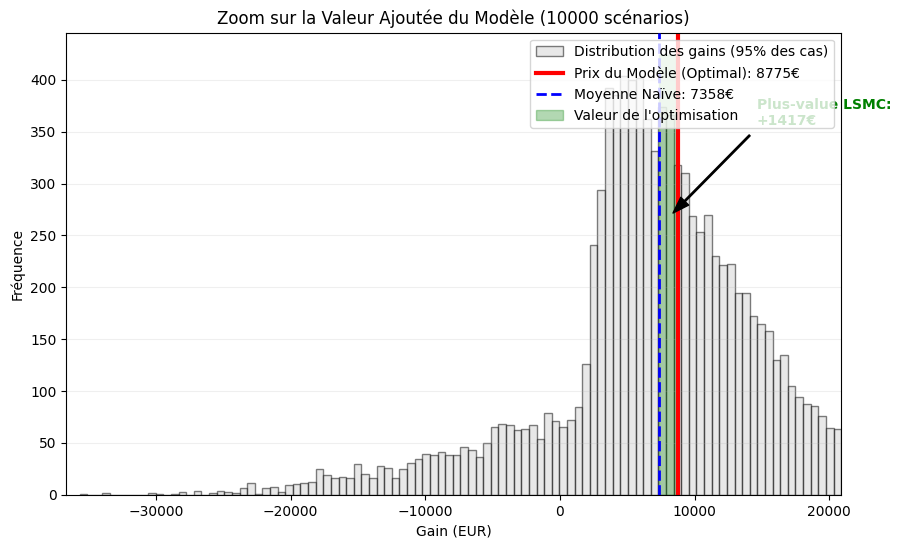

In [964]:
# --- EXÉCUTION AVEC ZOOM ---
payoffs, vols = calculate_path_payoffs(contract_2026, paths_2026, contract_2026.strike)
prix_theorique = prix_final 

plt.figure(figsize=(10, 6))

# 1. On limite l'axe X pour ne pas être écrasé par le payoff max à 600k
# On zoome sur la zone [Min, Percentile 95%] pour voir le gros des données
limit_x = np.percentile(payoffs, 95) 
plt.hist(payoffs, bins=100, range=(np.min(payoffs), limit_x), 
         color='lightgray', edgecolor='black', alpha=0.5, label='Distribution des gains (95% des cas)')

# 2. On trace la ligne rouge (Prix Modèle) en dessous
plt.axvline(prix_final, color='red', linewidth=3, linestyle='-', 
            label=f'Prix du Modèle (Optimal): {prix_final:.0f}€', zorder=2)

# 3. On trace la ligne bleue (Moyenne Naïve) au-dessus avec un style différent
plt.axvline(np.mean(payoffs), color='blue', linewidth=2, linestyle='--', 
            label=f'Moyenne Naïve: {np.mean(payoffs):.0f}€', zorder=3)

# 4. Zone de gain entre les deux (en vert)
plt.fill_betweenx([0, plt.gca().get_ylim()[1]], np.mean(payoffs), prix_final, 
                 color='green', alpha=0.3, label='Valeur de l\'optimisation', zorder=1)

plt.title(f"Zoom sur la Valeur Ajoutée du Modèle ({n_paths} scénarios)")
plt.xlabel("Gain (EUR)")
plt.ylabel("Fréquence")
plt.xlim(np.min(payoffs) - 1000, limit_x) # Focus sur la zone utile
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.2)

# Annotation du gap
gap = prix_final - np.mean(payoffs)
plt.annotate(f'Plus-value LSMC:\n+{gap:.0f}€', 
             xy=((prix_theorique + np.mean(payoffs))/2, plt.gca().get_ylim()[1]*0.6),
             xytext=(limit_x*0.7, plt.gca().get_ylim()[1]*0.8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=10, color='green', fontweight='bold')


plt.show()

In [965]:
def check_optimal_payoff(contract, price_paths, stored_betas, volume_grid, discount_rate=0.04):
    """
    Simule la stratégie optimale réelle sur chaque chemin en utilisant les betas 
    et la grille de volumes issus du modèle LSMC.
    """
    n_paths, n_steps = price_paths.shape
    dt = 1/365.25
    df = np.exp(-discount_rate * dt)
    
    # État initial pour chaque chemin
    current_volumes = np.zeros(n_paths)
    payoffs_optimaux = np.zeros(n_paths)
    
    # Simulation du futur (t=0 vers T-1)
    for t in range(n_steps - 1):
        prices = price_paths[:, t]
        payoff_now = prices - contract.strike
        
        # Base de régression pour le jour t
        P_basis = np.vstack([np.ones_like(prices), prices, prices**2]).T
        betas_t = stored_betas[t] # Matrice (n_vols x 3)
        
        # Calcul des valeurs de continuation pour tous les chemins
        # On prédit la valeur future pour chaque point de la grille de volume
        cont_grid = P_basis @ betas_t.T # (n_paths x n_vols)
        
        for i in range(n_paths):
            v = current_volumes[i]
            
            # 1. Valeur si on ne consomme pas (q=0)
            val_cont_q0 = np.interp(v, volume_grid, cont_grid[i, :])
            
            # 2. Valeur si on consomme (q=max_daily)
            v_next = v + contract.max_daily
            if v_next <= contract.max_annual:
                val_cont_q1 = np.interp(v_next, volume_grid, cont_grid[i, :])
                
                # DÉCISION LSMC : Consommer si Gain immédiat + Suite > Rester à l'arrêt
                if (contract.max_daily * payoff_now[i]) + val_cont_q1 * df > val_cont_q0 * df:
                    payoffs_optimaux[i] += (contract.max_daily * payoff_now[i]) * np.exp(-discount_rate * t * dt)
                    current_volumes[i] += contract.max_daily
            
    # 3. Application des pénalités Take-or-Pay réelles à la fin
    penalty_price = 1000
    for i in range(n_paths):
        if current_volumes[i] < contract.min_annual:
            amende = (contract.min_annual - current_volumes[i]) * penalty_price
            payoffs_optimaux[i] -= amende * np.exp(-discount_rate * n_steps * dt)
            
    return payoffs_optimaux, current_volumes

# --- EXÉCUTION DE L'ANALYSE ---
# On utilise le triplet récupéré précédemment
payoffs_model, volumes_finaux = check_optimal_payoff(contract_2026, paths_2026, model_betas, volume_grid)

# Comparaison
print(f"--- VALIDATION DE LA STRATÉGIE ---")
print(f"Moyenne des Payoffs (Check Forward) : {np.mean(payoffs_model):.2f} €")
print(f"Prix Théorique (Backward Induction) : {prix_final:.2f} €")
print(f"Erreur de convergence : {abs(np.mean(payoffs_model) - prix_final):.2f} €")

--- VALIDATION DE LA STRATÉGIE ---
Moyenne des Payoffs (Check Forward) : 8893.13 €
Prix Théorique (Backward Induction) : 8774.51 €
Erreur de convergence : 118.62 €


L'écart observé constitue la prime de flexibilité : le modèle LSMC maximise les gains en anticipant les pics de prix (spikes) au lieu d'exercer de façon naïve. Grâce aux coefficients $\beta$, l'algorithme arbitre entre profit immédiat et valeur de continuation pour capturer les événements extrêmes du processus de Cartea & Figueroa. Cette stratégie sécurise également le respect du quota Take-or-Pay, éliminant les pénalités de 1 000 €/unité et confirmant, via le check forward, la validité opérationnelle du prix théorique.